# Batch Analysis

In this notebook, we'll learn how to analyze EIS data in batch mode. Normally, you have a single set of EIS data, i.e., set of impedance measurements at various frequencies, plus a common circuit model that you want to fit to the data. This is what we call single circuit, single dataset or SCSD in short. However, there are two other modes of analysis that you might encounter in practice:

- Single circuit, multiple datasets (SCMD): You have multiple datasets, each with its own impedance measurements, but you want to fit the same circuit model to all of them. A good example of this is when you have EIS data for multiple samples which you want to compare, or a single sample under different conditions, e.g., EIS data at different cycles during battery cycling.

- Multiple circuits, single dataset (MCSD): You have a single dataset, but you want to fit different circuit models to it. This is useful when you want to compare different models to see which one fits the data best, which is by the way the classic use case of AutoEIS itself!

In [1]:
import random

import autoeis as ae
import matplotlib.pyplot as plt

ae.visualization.set_plot_style()

## Single circuit, multiple datsets (SCMD)

To test this, we can use a toy dataset that ships with the package. This dataset contains EIS data for a coin cell battery measured at discharged state at various cycles. Let's load the dataset and see what it looks like.

In [2]:
datasets = ae.io.load_battery_dataset()
print(f"Number of cycles: {len(datasets)}")

Number of cycles: 130


To save time searching for the optimal circuit by calling the `generate_equivalent_circuits` function, we will use the circuit that we know fits the data well.

In [3]:
circuit = "R1-P2-[R3,P4]-[R5,P6]"

Now, let's run Bayesian inference on the entire dataset using the given circuit. For convenience, the API for SCSD, SCMD, and MCSD is the same, so we just need to call `perform_bayesian_inference` with the appropriate arguments: the circuit string, list of frequencies, and list of impedance measurements. Since the loaded dataset is in the form of a list of tuples (frequency, impedance), we can easily extract the frequencies and impedances:

In [4]:
freq, Z = zip(*datasets)
# If you don't understand the above syntax, you can use the following code instead
# freq, Z = [], []
# for dataset in datasets:
#     freq.append(dataset[0])
#     Z.append(dataset[1])

<div class="alert alert-info">

Note

`perform_bayesian_inference` can handle all three modes of analysis: SCSD, MCSD, and SCMD. You only need to pass the appropriate arguments. The main three arguments are: `circuit`, `freq`, and `Z`. If any of these arguments is a list, then the function will automatically switch to the corresponding mode of analysis. Of course, you need to make sure the arguments are consistent, e.g., for SCMD, the length of `freq` and `Z` must be the same, etc.

</div>

Now, `freq` and `Z` are lists of frequencies and impedances, respectively, each associated with a different cycle. We can now call `perform_bayesian_inference` with these lists to get the posterior distributions for the circuit parameters for each cycle.

In [5]:
results = ae.perform_bayesian_inference(circuit, freq, Z)

Refining Initial Guess:   0%|          | 0/130 [00:00<?, ?it/s]

Performing Bayesian Inference:   0%|          | 0/130 [00:00<?, ?it/s]

`results` is a list of `InferenceResult` objects. Each object contains the posterior distributions for the circuit parameters for a single cycle with other useful information. Let's take a look, e.g., let's see how many of the inferences converged:

In [6]:
for i, result in enumerate(results):
    if not result.converged:
        print(f"Inference for cycle {i+1:3}/{len(results)} did not converge")

Now, let's inspect a sample inference result randomly picked from the list:

List of InferenceResult attributes/methods:
  >> Z
  >> circuit
  >> converged
  >> freq
  >> mcmc
  >> num_divergences
  >> print_summary
  >> samples
  >> variables


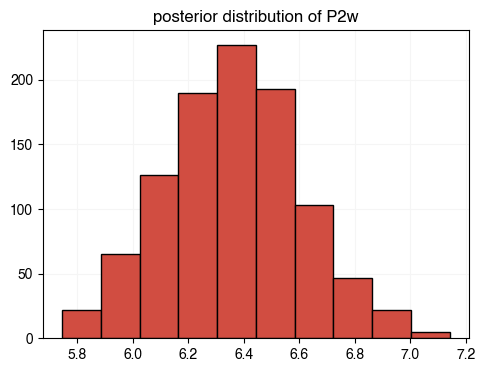

In [7]:
while True:
    result = random.choice(results)
    if result.converged:
        break

# Randomly select a parameter and plot its posterior distribution
param = random.choice(result.variables)
fig, ax = plt.subplots(figsize=(5.5, 4))
ax.hist(result.samples[param])
ax.set_title(f"posterior distribution of {param}")

# Let's list InferenceResult attributes/methods
print(
    "List of InferenceResult attributes/methods:\n  >>",
    "\n  >> ".join(attr for attr in dir(result) if not attr.startswith("_")),
)

This was just a quick overview, but you can do all sorts of analyses with the results, e.g., plotting the evolution of posterior distributions as a function of cycle number in form of violin plots, etc.

## Single circuit, single dataset (SCSD)

We've already covered how to use `perform_bayesian_inference` for SCMD in the previous section. For SCSD, you just need to pass a single impedance dataset to the function, i.e., a NumPy array instead of a list of arrays. The rest of the process is the same!

## Multiple circuits, single dataset (MCSD)

Similarly, you can use `perform_bayesian_inference` for MCSD by passing a list of circuit strings instead of a single string. Alternatively, you can pass a dataframe, but it needs to be formatted with columns named `circuitstring`, and `Parameters` with the circuit strings and initial guesses for the parameters, respectively. This unusual format is for legacy reasons and might be changed in the future.

## Multiple circuits, multiple datasets (MCMD)

You might ask, what about MCMD? Well, we can easily extend the API to support this mode of analysis, but we couldn't find an actual use case for it, so it's not implemented to keep the codebase sane! If you really need this feature, you can easily implement it yourself by calling `perform_bayesian_inference` in a loop over the datasets!